In [1]:
import numpy as np
import abcpmc  # pip install abcpmc
import matplotlib.pylab as plt
%matplotlib inline

KNN
T: 0, eps: 3.0000, ratio: 0.6711
    theta[0]: 1.0706 ± 0.4796
    theta[1]: 1.1006 ± 0.5006
T: 1, eps: 2.0965, ratio: 0.4292
    theta[0]: 0.9688 ± 0.3973
    theta[1]: 1.0830 ± 0.3982
T: 2, eps: 1.4651, ratio: 0.2105
    theta[0]: 1.0339 ± 0.2924
    theta[1]: 1.0657 ± 0.3461
T: 3, eps: 1.0238, ratio: 0.0793
    theta[0]: 1.0807 ± 0.2172
    theta[1]: 1.1051 ± 0.2699
T: 4, eps: 0.7155, ratio: 0.0243
    theta[0]: 1.0870 ± 0.1570
    theta[1]: 1.1464 ± 0.1982
T: 5, eps: 0.5000, ratio: 0.0102
    theta[0]: 1.1030 ± 0.1418
    theta[1]: 1.1526 ± 0.1839
CPU times: user 6.87 s, sys: 68.6 ms, total: 6.94 s
Wall time: 7.06 s


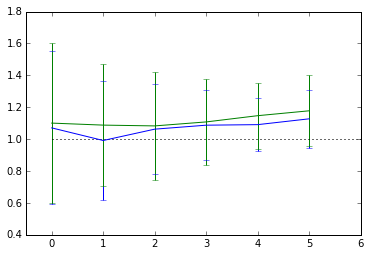

In [15]:
#create "observed" data set
def abc_test(Npart=50,part_prop='KNN',knn=5, threshold = 'ExpEps',epimax = 3., epimin = .5, Iter = 4):
    #make simple mock data
    size = 2
    sigma = np.eye(size) * 0.2
    means = np.ones(size)
    data = np.random.multivariate_normal(means, sigma, size)
    #-------

    #distance function: sum of abs mean differences
    def dist(x, y):
        #return np.sum(np.abs(np.mean(x, axis=0) - np.mean(y, axis=0)))
        return np.sum(np.abs((x) - (y)))

    #our "model", a gaussian with varying means
    def postfn(theta):
        return np.random.multivariate_normal(theta, sigma, size)
    
    if threshold == 'ConstEps':
        eps = abcpmc.ConstEps(Iter, epimax)
    elif threshold == 'ExpEps':
        eps = abcpmc.ExponentialEps(Iter, epimax,epimin)
    else:
        eps = abcpmc.LinearEps(Iter, epimax, epimin)
        
        
    prior = abcpmc.GaussianPrior(means*1.1, sigma*2) #our best guess

    sampler = abcpmc.Sampler(N=Npart, Y=data, postfn=postfn, dist=dist)
    
    
    print part_prop
    abcpmc.Sampler.particle_proposal_kwargs = {}
    if part_prop == 'KNN':
        abcpmc.Sampler.particle_proposal_kwargs = {'k':knn}
        sampler.particle_proposal_cls = abcpmc.KNNParticleProposal
    elif part_prop == 'OLCM':
        sampler.particle_proposal_cls = abcpmc.OLCMParticleProposal
    
    pools=[]   
    for pool in sampler.sample(prior, eps):
        print("T: {0}, eps: {1:>.4f}, ratio: {2:>.4f}".format(pool.t, pool.eps, pool.ratio))
        for i, (mean, std) in enumerate(zip(np.mean(pool.thetas, axis=0), np.std(pool.thetas, axis=0))):
            print(u"    theta[{0}]: {1:>.4f} \u00B1 {2:>.4f}".format(i, mean,std))
        pools.append(pool)
    for i in range(len(means)):
        moments = np.array([abcpmc.weighted_avg_and_std(pool.thetas[:,i], pool.ws, axis=0) for pool in pools])
        plt.errorbar(range(Iter), moments[:, 0], moments[:, 1])
    plt.hlines(means, 0, Iter, linestyle="dotted", linewidth=0.7)
    _ = plt.xlim([-.5, Iter])
    return pools
            
%time pools = abc_test(Npart = 100,part_prop ='KNN',knn=5,threshold ='ExpEps',Iter = 6)

__references for further reading__

**Good tutorial**
Turner & Vandelt 2012
http://www.sciencedirect.com/science/article/pii/S0022249612000272


"Akeret, J., Refregier, A., Amara, A, Seehars, S., and Hasner, C., JCAP (submitted 2015)"
"Beaumont et al. 2009 arXiv:0805.2256"
"Fillippi et al 2012 arXiv:1106.6280"

Example applied to SN cosmology
http://arxiv.org/abs/1206.2563